# Largest Threads: SPI30d
a. stein 5.3.2023

Let's find the largest events in each network and do some intersecting. This was already done for SPI180d as node 1517

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network_v12 as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

import geopandas as gpd

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/drought_threads/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [5]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [6]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

In [7]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

## Largest SPI30d

In [8]:
largest_id = 0
largest_size = 0

for node in spi30d_net.nodes:
    if len(node.coords) > largest_size:
        largest_id = node.id
        largest_size = len(node.coords)

spi30d_ln = spi30d_net.nodes[largest_id]
spi30d_ln

time: 890, id: 1771

In [9]:
paired_ds['SPI Date'].sel(index=spi30d_ln.time).values

numpy.datetime64('2017-01-20T00:00:00.000000000')

In [10]:
intersect_time = paired_ds['SPI Date'].sel(index=spi30d_ln.time).values

Okay, that's going to be included in the thread we already found with spi180d ... but I can see if this one intersects with the USDM

In [11]:
spi30d_ln_cs = set(tuple(coord) for coord in spi30d_ln.coords) # cs = coord set

In [12]:
usdm_tm = []

for node in usdm_net:
    if node.time == spi30d_ln.time:
        print(node)
        usdm_tm.append(node)

time: 890, id: 1363, futures: [1364]


In [13]:
usdm_tracer_nodes = []
for node in usdm_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    intersect = len(spi30d_ln_cs.intersection(node_cs))
    print(intersect)
    if intersect > 0:
        usdm_tracer_nodes.append(node)

13735


In [14]:
spi180d_tm = []

for node in spi180d_net:
    if node.time == spi30d_ln.time:
        print(node)
        spi180d_tm.append(node)

time: 890, id: 1477, futures: [1483]
time: 890, id: 1478, futures: [1484]
time: 890, id: 1479, futures: [1485]
time: 890, id: 1480, futures: [1486]
time: 890, id: 1481, futures: [1487]
time: 890, id: 1482, futures: [1488]


In [15]:
spi180d_tracer_nodes = []

for node in spi180d_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    intersect = len(spi30d_ln_cs.intersection(node_cs))
    print(intersect)
    if intersect > 0: 
        spi180d_tracer_nodes.append(node)

0
39955
4420
1932
1861
3002


Good good.

In [16]:
spi30d_trace = spi30d_net.get_full_thread([spi30d_ln])

In [17]:
for node in spi180d_tracer_nodes:
    node.id

In [18]:
spi180d_trace = spi180d_net.get_full_thread(nodes=spi180d_tracer_nodes)

In [19]:
usdm_trace = usdm_net.get_full_thread(nodes=usdm_tracer_nodes)

In [20]:
spi30d_times = [node.time for node in spi30d_trace]
start_time = np.min(spi30d_times)
end_time = np.max(spi30d_times)

In [21]:
spi30d_array = spi30d_net.node_array(spi30d_trace, start_time, end_time)

In [22]:
spi30d_array.shape

(27, 702, 525)

In [23]:
spi180d_array = spi180d_net.node_array(spi180d_trace, start_time, end_time)

In [24]:
usdm_array = usdm_net.node_array(usdm_trace, start_time, end_time)

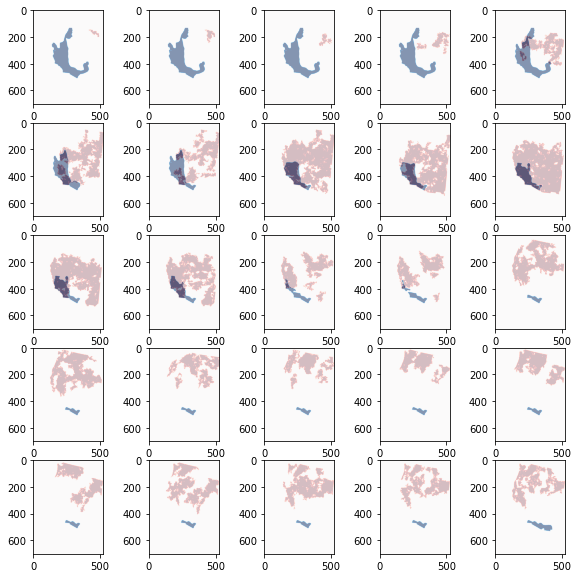

In [25]:
fig, axs = plt.subplots(5,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi30d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(usdm_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

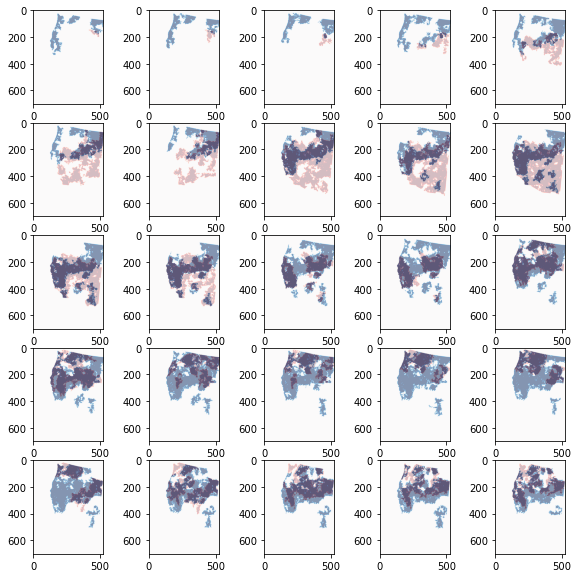

In [26]:
fig, axs = plt.subplots(5,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi30d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(spi180d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

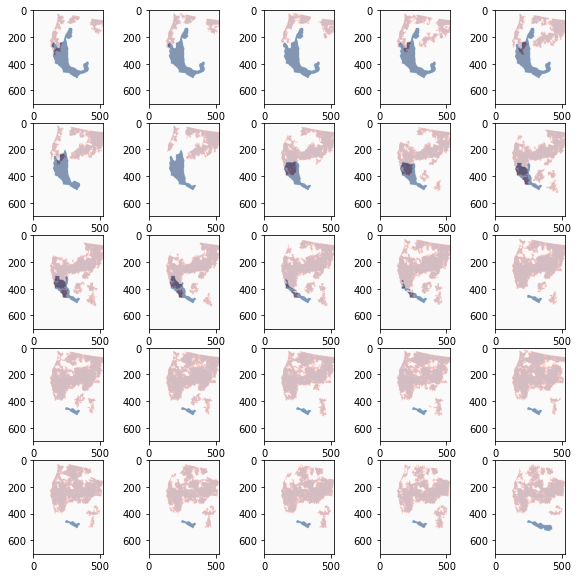

In [27]:
fig, axs = plt.subplots(5,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi180d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(usdm_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

In [28]:
usdm_array.shape

(27, 702, 525)

In [29]:
end_time - start_time

26

In [30]:
df = gpd.read_file('/pool0/home/steinjao/data/drought/drought_impact/data/geometry/tl_2022_us_state.shp')
df.to_crs("EPSG:4326");
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

In [31]:
usdm_array_da = xr.DataArray(
    usdm_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['USDM Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
usdm_array_da = usdm_array_da.rio.reproject('EPSG:4326', nodata=0)
#usdm_array_da

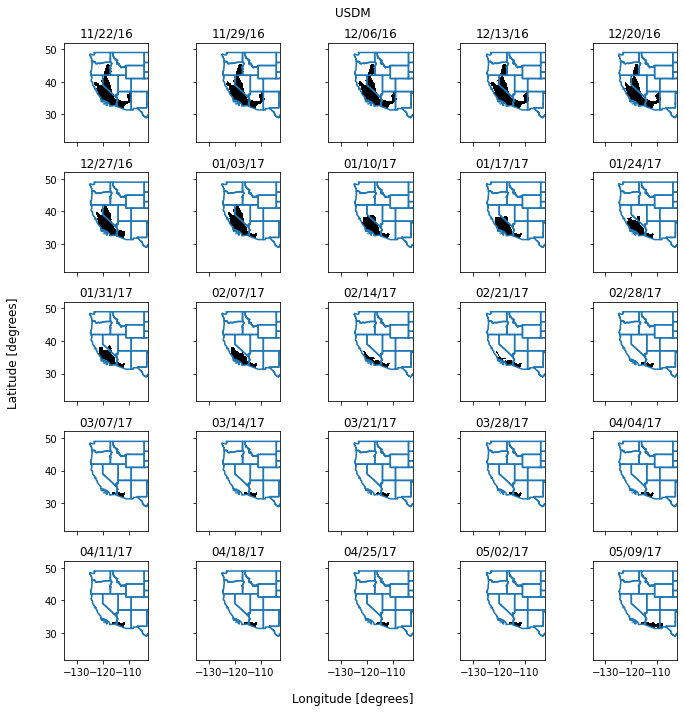

In [40]:
fig, axs = plt.subplots(5,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    usdm_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(usdm_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('USDM')
fig.set_facecolor('w')
plt.tight_layout()

In [33]:
spi30d_array_da = xr.DataArray(
    spi30d_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['SPI Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
spi30d_array_da = spi30d_array_da.rio.reproject('EPSG:4326', nodata=0)

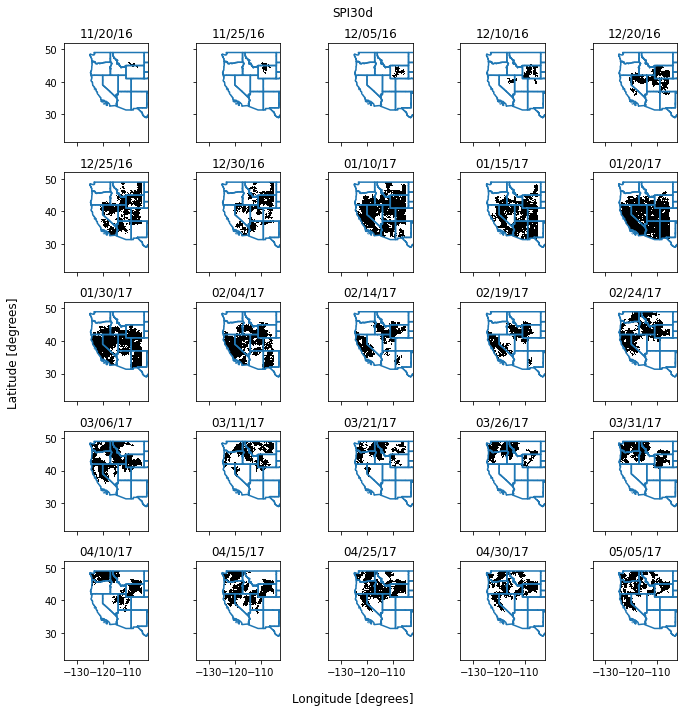

In [41]:
fig, axs = plt.subplots(5,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    spi30d_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi30d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI30d')
fig.set_facecolor('w')
plt.tight_layout()

In [35]:
spi180d_array_da = xr.DataArray(
    spi180d_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['SPI Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
spi180d_array_da = spi180d_array_da.rio.reproject('EPSG:4326', nodata=0)

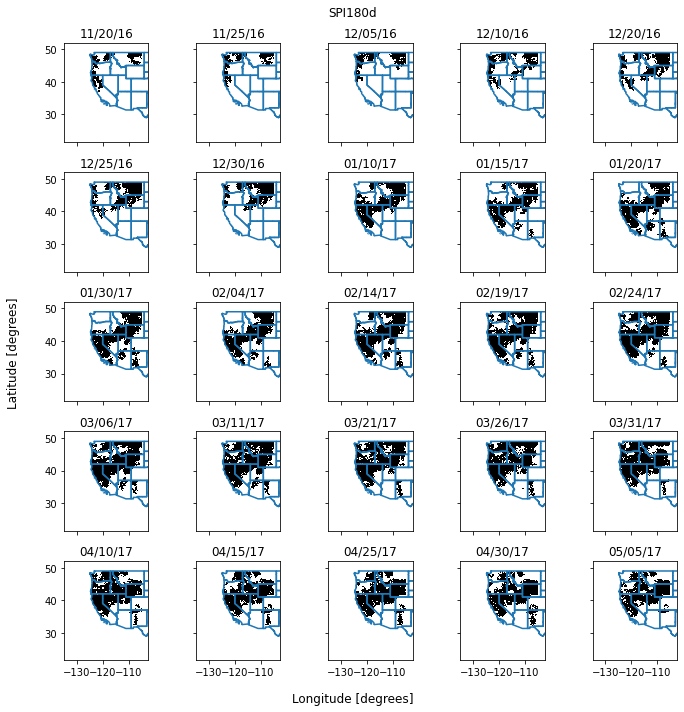

In [42]:
fig, axs = plt.subplots(5,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    spi180d_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi180d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI180d')
fig.set_facecolor('w')
plt.tight_layout()

In [37]:
intersect_time

numpy.datetime64('2017-01-20T00:00:00.000000000')

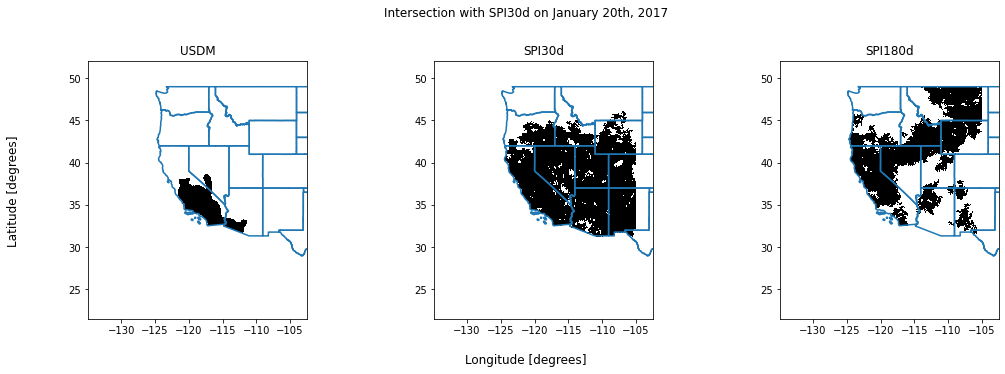

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

usdm_array_da.sel(t=intersect_time+pd.Timedelta('4day')).plot(ax=axs[0], cmap='Greys', add_colorbar=False)
spi30d_array_da.sel(t=intersect_time).plot(ax=axs[1], cmap='Greys', add_colorbar=False)
spi180d_array_da.sel(t=intersect_time).plot(ax=axs[2], cmap='Greys', add_colorbar=False)

axs[0].set_title('USDM')
axs[1].set_title('SPI30d')
axs[2].set_title('SPI180d')

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)

fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('Intersection with SPI30d on January 20th, 2017', y=1.01)
fig.set_facecolor('w')

plt.tight_layout()

In [43]:
spi30d_spi180d_on = dnet.overlap_nodes(spi30d_trace, spi180d_trace)

  0%|          | 0/55 [00:00<?, ?it/s]

In [44]:
spi30d_usdm_on = dnet.overlap_nodes(spi30d_trace, usdm_trace)

  0%|          | 0/55 [00:00<?, ?it/s]

In [45]:
spi180d_usdm_on = dnet.overlap_nodes(spi180d_trace, usdm_trace)

  0%|          | 0/161 [00:00<?, ?it/s]

In [46]:
aa_spi30d_spi180d = dnet.compute_alignment_area(spi30d_spi180d_on)

In [47]:
aa_spi30d_usdm = dnet.compute_alignment_area(spi30d_usdm_on)

In [48]:
aa_spi180d_usdm = dnet.compute_alignment_area(spi180d_usdm_on)

In [49]:
da_spi30d_usdm, da_usdm_spi30d = dnet.compute_disagreement_area(spi30d_net, usdm_net, spi30d_usdm_on)

In [50]:
da_spi30d_spi180d, da_spi180d_spi30d = dnet.compute_disagreement_area(spi30d_net, spi180d_net, spi30d_spi180d_on)

In [51]:
da_spi180d_usdm, da_usdm_spi180d = dnet.compute_disagreement_area(spi180d_net, usdm_net, spi180d_usdm_on)

In [52]:
def aa_da_trace_plot(
        aa, da_1, da_2, path_1, path_2,
        aa_name, name_1, name_2,
        aa_color, color_1, color_2,
        grid_to_area, dates, ax=None
):
    
    aa_all = dict()
    for pairing in aa:
        aa_all.update(pairing)

    pre_sort_times = np.hstack([list(aa_all.keys())])
    times = np.sort(pre_sort_times)
    plot_dates = dates[times]

    aa_plot_vals = np.hstack([aa_all[time] for time in times])
    da_1_vals = []
    for time in times:
        try:
            da_1_vals.append(da_1[time]*grid_to_area)
        except:
            da_1_vals.append(0)
    da_2_vals = []
    for time in times:
        try:
            da_2_vals.append(da_2[time]*grid_to_area)
        except:
            da_2_vals.append(0)

    areas_1 = dict()
    for node in path_1:
        if not node.time in areas_1.keys():
            areas_1[node.time] = 0
        areas_1[node.time] += len(node.coords)*grid_to_area
    areas_2 = dict()
    for node in path_2:
        if not node.time in areas_2.keys():
            areas_2[node.time] = 0
        areas_2[node.time] += len(node.coords)*grid_to_area

    if ax is None:
        __, ax = plt.subplots()

    ax.plot(plot_dates, aa_plot_vals*grid_to_area, label=aa_name, color=aa_color, marker='.')
    ax.plot(plot_dates, da_1_vals, label=f'{name_1} DA', color=color_1, marker='.')
    ax.plot(plot_dates, da_2_vals, label=f'{name_2} DA', color=color_2, marker='.')

    ax.plot(
        plot_dates,
        np.hstack([areas_1[time] for time in times]), label=f'{name_1} Area', color=color_1, linestyle='--', marker='.'
    )
    ax.plot(
        plot_dates,
        np.hstack([areas_2[time] for time in times]), label=f'{name_2} Area', color=color_2, linestyle='--', marker='.'
    )

    ax.set_ylabel('Area (km2)')
    ax.set_xlabel('Date')

    return ax

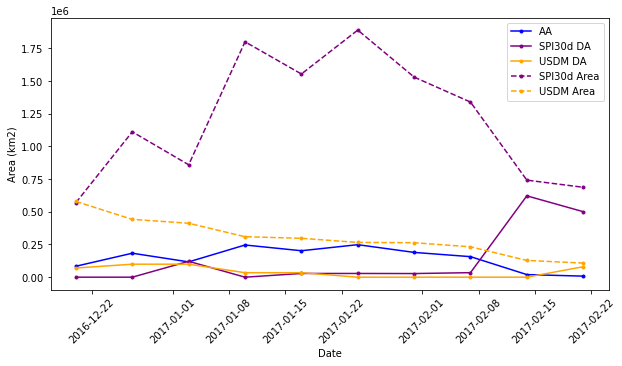

In [62]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_spi30d_usdm, da_spi30d_usdm, da_usdm_spi30d, 
    spi30d_trace, usdm_trace,
    'AA', 'SPI30d', 'USDM',
    'b', 'purple', 'orange',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
ax.tick_params('x', rotation=45)
fig.set_facecolor('w')
#ax.set_yscale('symlog')
#ax.set_xlim(xmin, xmax)

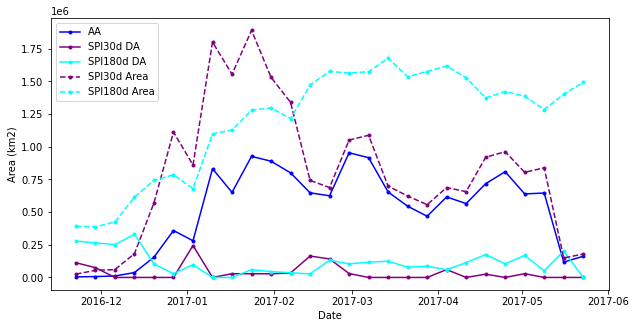

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_spi30d_spi180d, da_spi30d_spi180d, da_spi180d_spi30d,
    spi30d_trace, spi180d_trace,
    'AA', 'SPI30d', 'SPI180d',
    'b', 'purple', 'cyan',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
fig.set_facecolor('w')
#ax.set_xlim(xmin, xmax)

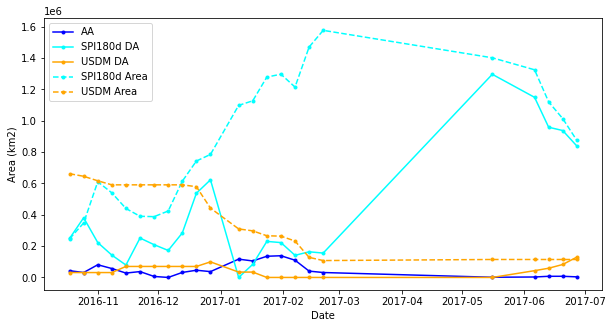

In [55]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_spi180d_usdm, da_spi180d_usdm, da_usdm_spi180d,
    spi180d_trace, usdm_trace,
    'AA', 'SPI180d', 'USDM',
    'b', 'cyan', 'orange',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
fig.set_facecolor('w')
#xmin, xmax = ax.get_xlim()

In [56]:
aa_all = dict()
for pairing in aa_spi180d_usdm:
    aa_all.update(pairing)

pre_sort_times = np.hstack([list(aa_all.keys())])
times = np.sort(pre_sort_times)
times

array([876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 888, 889,
       890, 891, 892, 893, 894, 906, 909, 910, 911, 912])

In [57]:
aa_spi180d_usdm

[{889: 5813},
 {888: 6451},
 {886: 2059},
 {885: 2542},
 {884: 1767},
 {883: 2},
 {882: 348},
 {881: 2066},
 {880: 1543},
 {879: 3143},
 {878: 4471},
 {877: 1739},
 {876: 2374},
 {890: 7469, 891: 7650, 892: 6080, 893: 2232, 894: 1737},
 {909: 160, 910: 405, 911: 410, 912: 204},
 {906: 66}]

In [58]:
aa_spi30d_usdm

[{889: 11175},
 {888: 13598},
 {887: 6461},
 {886: 10130},
 {885: 4630},
 {890: 13735, 891: 10471, 892: 8677, 893: 1097, 894: 444}]

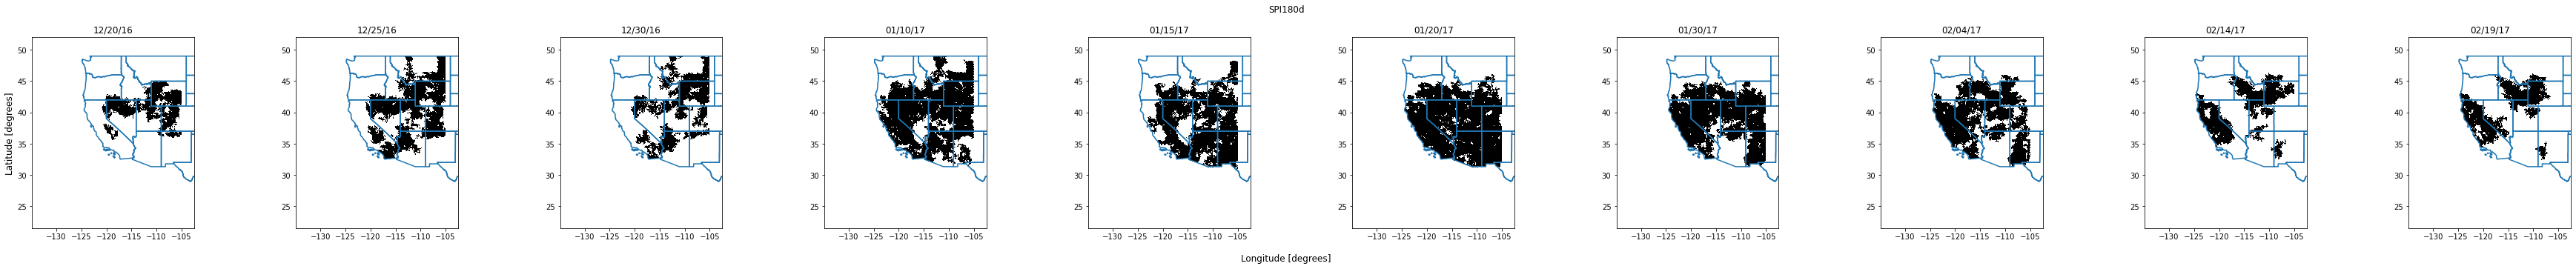

In [70]:
#4:13

fig, axs = plt.subplots(1, 10, figsize=(50,5))

for i, ax in zip(np.arange(4,14), axs.ravel()):
    spi30d_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi180d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI180d')
fig.set_facecolor('w')
plt.tight_layout()

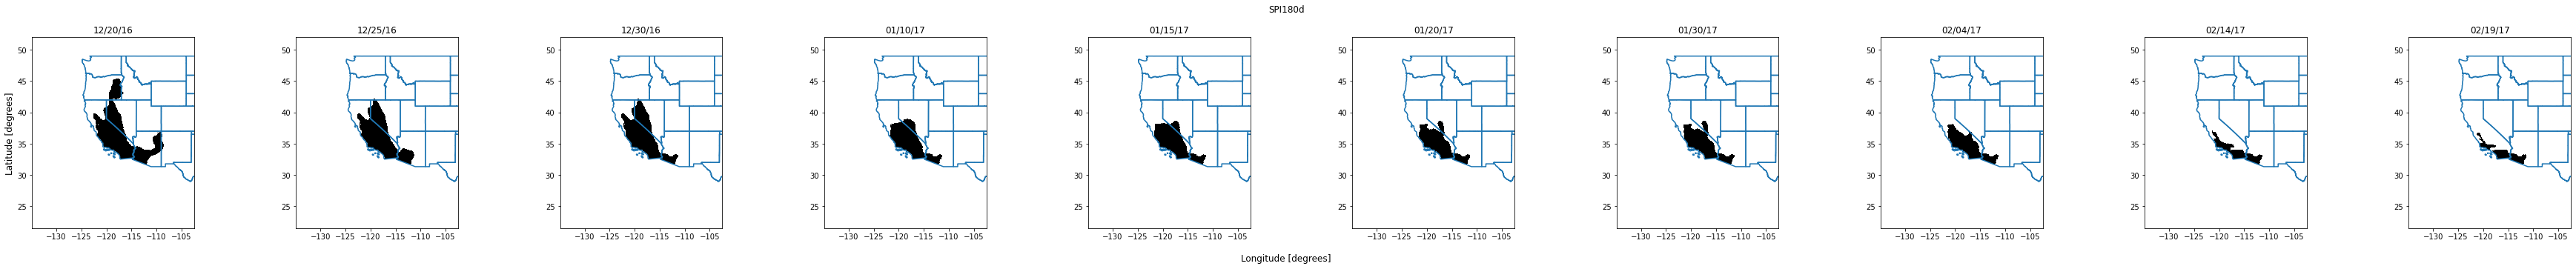

In [71]:
#4:13

fig, axs = plt.subplots(1, 10, figsize=(50,5))

for i, ax in zip(np.arange(4,14), axs.ravel()):
    usdm_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi180d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI180d')
fig.set_facecolor('w')
plt.tight_layout()